In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random


In [2]:
# ** Read ERA5 data
ERA5_raw = pd.read_csv("reanalysis.csv")
ERA5_raw["time"] = pd.to_datetime(ERA5_raw["Unnamed: 0"])
ERA5_raw.drop(columns=["Unnamed: 0"], inplace=True)
ERA5_raw.index = ERA5_raw["time"]

ERA5_data = ERA5_raw.resample('D').mean(numeric_only=True)
ERA5_data['month_of_year'] = ERA5_data.index.month

# ** Read Satellite data
satellite_data = pd.read_csv("satellite.csv")
satellite_data["time"] = pd.to_datetime(satellite_data["Unnamed: 0"])
satellite_data.drop(columns=["Unnamed: 0"], inplace=True)
satellite_data.index = satellite_data["time"]

satellite_data['month_of_year'] = satellite_data.index.month
satellite_data["sm_available"] = (~np.isnan(satellite_data["sm"])).astype(int)


In [3]:
# ** Calculate transition matrix for each month of the year
# State "1" ... SM is available
# State "0" ... SM is missing
transitions = {}
for month, group in satellite_data.groupby('month_of_year'):
    x = group['sm_available'].values
    P00 = ((x[:-1]==0) & (x[1:]==0)).sum() / (x[:-1]==0).sum()
    P01 = 1 - P00
    P11 = ((x[:-1]==1) & (x[1:]==1)).sum() / (x[:-1]==1).sum()
    P10 = 1 - P11
    transitions[month] = [[P00, P01],[P10,P11]]

# ** Simulate gaps 
states = []
current_state = 0 # Initial state
for month_of_day in ERA5_data["month_of_year"]:
    
    # Get current state from previous state by random sampling according to the transition matrix
    current_state = np.random.choice([0, 1], p=transitions[month_of_day][current_state])
    states.append(current_state)

ERA5_data["sim_sm_available"] = states



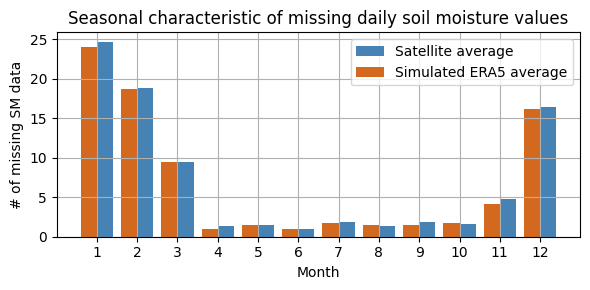

In [10]:
# ** Plot histogram of simulated gaps

def get_avg_monthly_missing(df, availability_column):
    monthly_missing_data = []
    for month in range(1,13):
        n_missing_datapoints = np.count_nonzero(df[availability_column][df["month_of_year"]==month]==0)
        monthly_missing_data.append(n_missing_datapoints)
    
    n_years = len(np.unique(df.index.year))
    return np.array(monthly_missing_data) / n_years

ERA5_monthly_missing = get_avg_monthly_missing(ERA5_data, "sim_sm_available")
satellite_monthly_missing = get_avg_monthly_missing(satellite_data, "sm_available")


w, months = 0.4, np.arange(1,13)
fig, ax = plt.subplots(figsize = (6,3))
ax.bar(months+w/2, satellite_monthly_missing, width=w,
       color = 'steelblue', label = "Satellite average")
ax.bar(months-w/2, ERA5_monthly_missing, width=w,
       color = 'chocolate', label = "Simulated ERA5 average")

ax.set_xticks(months)
ax.set_xticklabels(months)
ax.grid(True)
ax.set_ylabel("# of missing SM data")
ax.set_xlabel("Month")
ax.set_title("Seasonal characteristic of missing daily soil moisture values")
ax.legend()
plt.tight_layout()

# Evtl. wenn Zeit ist noch Länge der Gaps vergleichen